# Assessing Autism from Eye Movements Using Deep Learning: Refactored Pipeline

**Author:** Tal Alfi  
**Advisor:** Prof. Ohad Ben-Shahar  
**Institution:** Ben-Gurion University of the Negev  
**Last Updated:** May 2025

---

## Table of Contents

1. [Introduction](#1-introduction)
2. [Environment Setup](#2-environment-setup)
3. [Data Overview](#3-data-overview)
4. [Preprocessing Pipeline](#4-preprocessing-pipeline)
5. [Quality Assessment](#5-quality-assessment)
6. [Feature Extraction](#6-feature-extraction)
7. [Social Attention Analysis](#7-social-attention-analysis)
8. [Batch Processing](#8-batch-processing)
9. [Export & Save](#9-export-save)
10. [References](#10-references)

---

## 1. Introduction

This notebook implements a professional eye-tracking data preprocessing and analysis pipeline for autism spectrum disorder (ASD) research. The code has been refactored into a modular structure with proper Python modules located in the `src` directory.

### Key Features
- ✅ Organized, modular code structure
- ✅ Robust preprocessing with binocular validation
- ✅ Comprehensive quality assessment
- ✅ Advanced feature extraction
- ✅ Social attention analysis
- ✅ Batch processing capabilities

### Package Structure
```
src/
├── __init__.py        # Package initialization
├── preprocessing.py   # Data preprocessing functions
├── quality.py         # Quality assessment functions
├── features.py        # Feature extraction functions
├── visualization.py   # Visualization functions
└── utils.py           # Utility functions
```

## 2. Environment Setup

Import all required libraries and set up the analysis environment:

In [1]:
# Standard libraries
import os
import glob
import warnings
import json
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Union

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle, Circle

# Scientific computing
from scipy import stats, signal
from scipy.spatial import distance
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter1d

# Import our modules
from src import (
    # Preprocessing functions
    preprocess_eye_tracking_data,
    
    # Quality assessment
    calculate_comprehensive_quality_metrics,
    assess_data_quality,
    
    # Feature extraction
    extract_basic_features,
    extract_combined_features,
    ROIAnalyzer,
    
    # Visualization
    plot_gaze_trajectory,
    plot_disparity_analysis,
    plot_preprocessing_summary,
    plot_comprehensive_quality_trends,
    plot_social_attention_summary,
    
    # Utilities
    explore_data_structure,
    save_preprocessing_report,
    batch_preprocess_files,
    process_with_social_attention
)

# Machine Learning (optional)
try:
    import torch
    DL_FRAMEWORK = 'pytorch'
    print("✅ PyTorch available for deep learning")
except ImportError:
    try:
        import tensorflow as tf
        DL_FRAMEWORK = 'tensorflow'
        print("✅ TensorFlow available for deep learning")
    except ImportError:
        DL_FRAMEWORK = None
        print("⚠️ No deep learning framework found. Install PyTorch or TensorFlow.")

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set random seeds
np.random.seed(42)
if DL_FRAMEWORK == 'pytorch':
    torch.manual_seed(42)
elif DL_FRAMEWORK == 'tensorflow':
    tf.random.set_seed(42)

# Configuration
DATA_DIR = 'files/'
OUTPUT_DIR = 'output/'
FIGURE_DIR = 'figures/'
SCREEN_WIDTH = 1280
SCREEN_HEIGHT = 1024
SAMPLING_RATE = 500  # Hz

# Create output directories if they don't exist
for directory in [OUTPUT_DIR, FIGURE_DIR]:
    os.makedirs(directory, exist_ok=True)

print(f"✅ Environment setup complete!")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"📁 Figure directory: {FIGURE_DIR}")
print(f"📊 Available CSV files: {len(glob.glob(os.path.join(DATA_DIR, '*.csv')))}")

✅ PyTorch available for deep learning
✅ Environment setup complete!
📁 Data directory: files/
📁 Output directory: output/
📁 Figure directory: figures/
📊 Available CSV files: 7


## 3. Data Overview

Let's examine the structure of the eye-tracking data:

In [2]:
# Check if we have data files available
if len(glob.glob(os.path.join(DATA_DIR, '*.csv'))) > 0:
    sample_file = glob.glob(os.path.join(DATA_DIR, '*.csv'))[0]
    df_sample = explore_data_structure(sample_file)
else:
    print("⚠️ No CSV files found in the data directory.")

📊 Data Structure Analysis
Subject ID: 1024539343
Total samples: 45,010
Columns: 24
Recording duration: 90.02 seconds
Effective sampling rate: 500.01 Hz

📋 Column Information:
Column                    Type       Missing %  Description
----------------------------------------------------------------------
timestamp                 int64      0.0        Recording timestamp (ms)
frame_number              float64    0.0        Video frame number
x_left                    float64    1.1        Left eye X coordinate
y_left                    float64    1.1        Left eye Y coordinate
pupil_left                float64    1.1        Left pupil diameter
x_right                   float64    0.9        Right eye X coordinate
y_right                   float64    0.9        Right eye Y coordinate
pupil_right               float64    0.9        Right pupil diameter
input                     float64    100.0      Additional metric
cr_info                   object     99.5       Additional metric
cr_

## 4. Preprocessing Pipeline

Process a single eye-tracking file using our refactored preprocessing pipeline:


🚀 Complete Preprocessing Pipeline
File: 1024539343_unified_eye_metrics_Dinstein_Girls_90_SecX.csv
Removing 2 columns with >95% missing data:
  - input: 100.0% missing
  - cr_info: 99.5% missing
✓ Step 1: Loaded data (45,010 samples)
✓ Step 2: Added helper features
✓ Gaze label check: 50.8% of samples have right eye gaze to the right of left eye gaze
   Mean horizontal gaze difference: 6.7px
✓ Step 3: Checked gaze labeling
👁️ Eye tracking quality analysis:
   Left eye noise score:  3536.65
   Right eye noise score: 3464.15
✓ Both eyes have similar tracking quality (ratio: 1.02)
✓ Step 4: Stabilized noisy eye tracking
👁️ Blink Detection and Handling
  Left eye: 3 blinks, 7 gaps
  Right eye: 0 blinks, 3 gaps
Found 560 monocular samples (1.2%)
After enforcement: 44301 valid binocular samples (98.4%)
🔧 Automatic Binocular Calibration
  Detected bias: (61.0, 0.4) pixels
  Based on 672 stable samples
  Disparity reduced: 66.6 → 32.3 pixels
  Improvement: 51.5%
⚠️ Found 3343 samples with exce

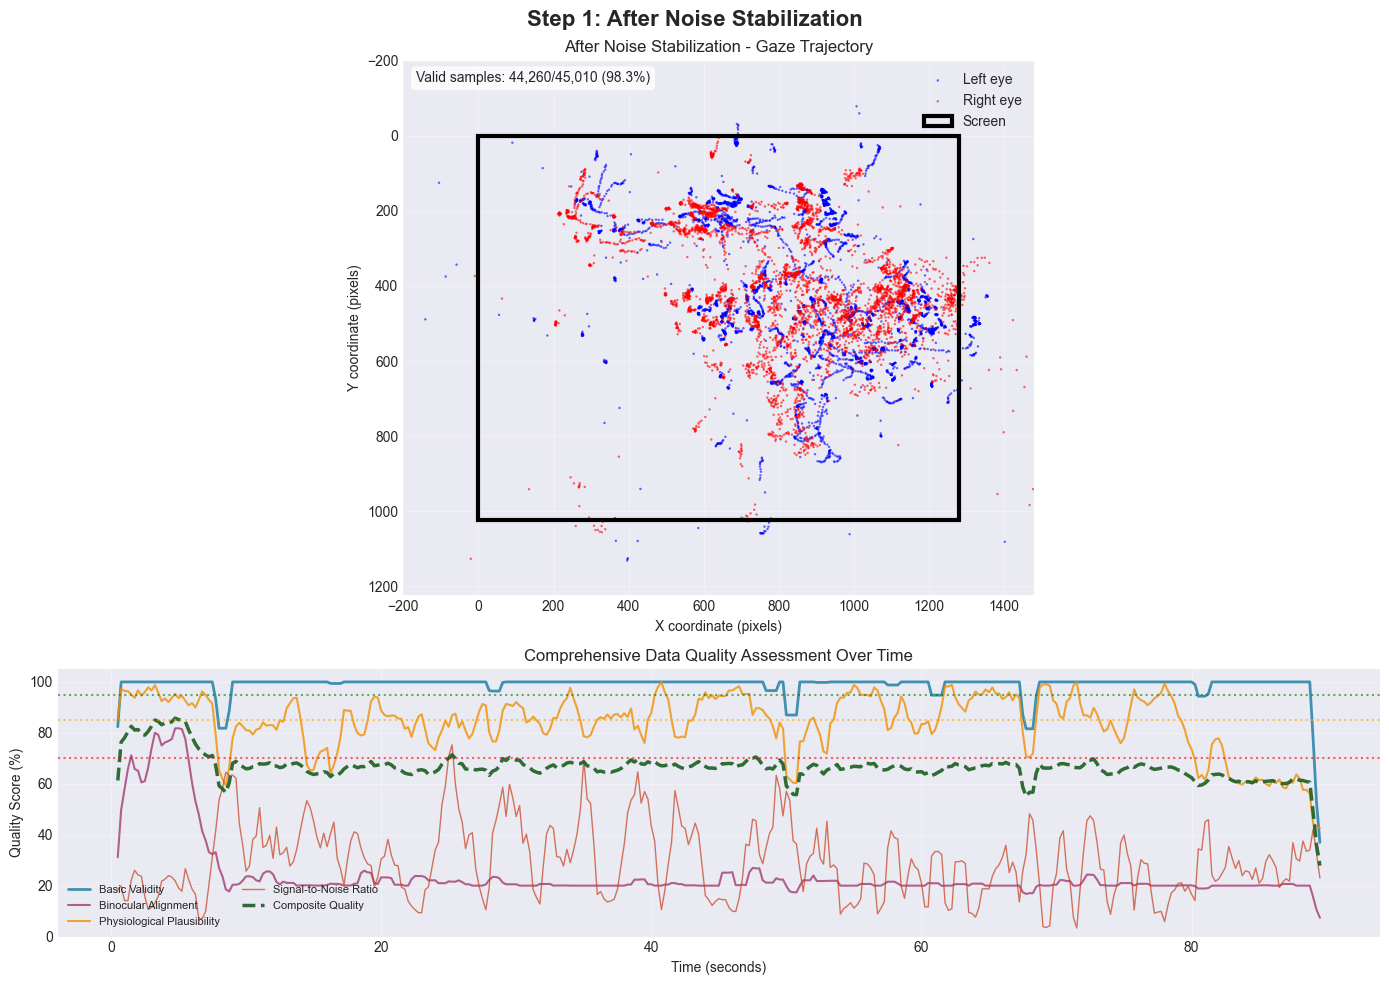

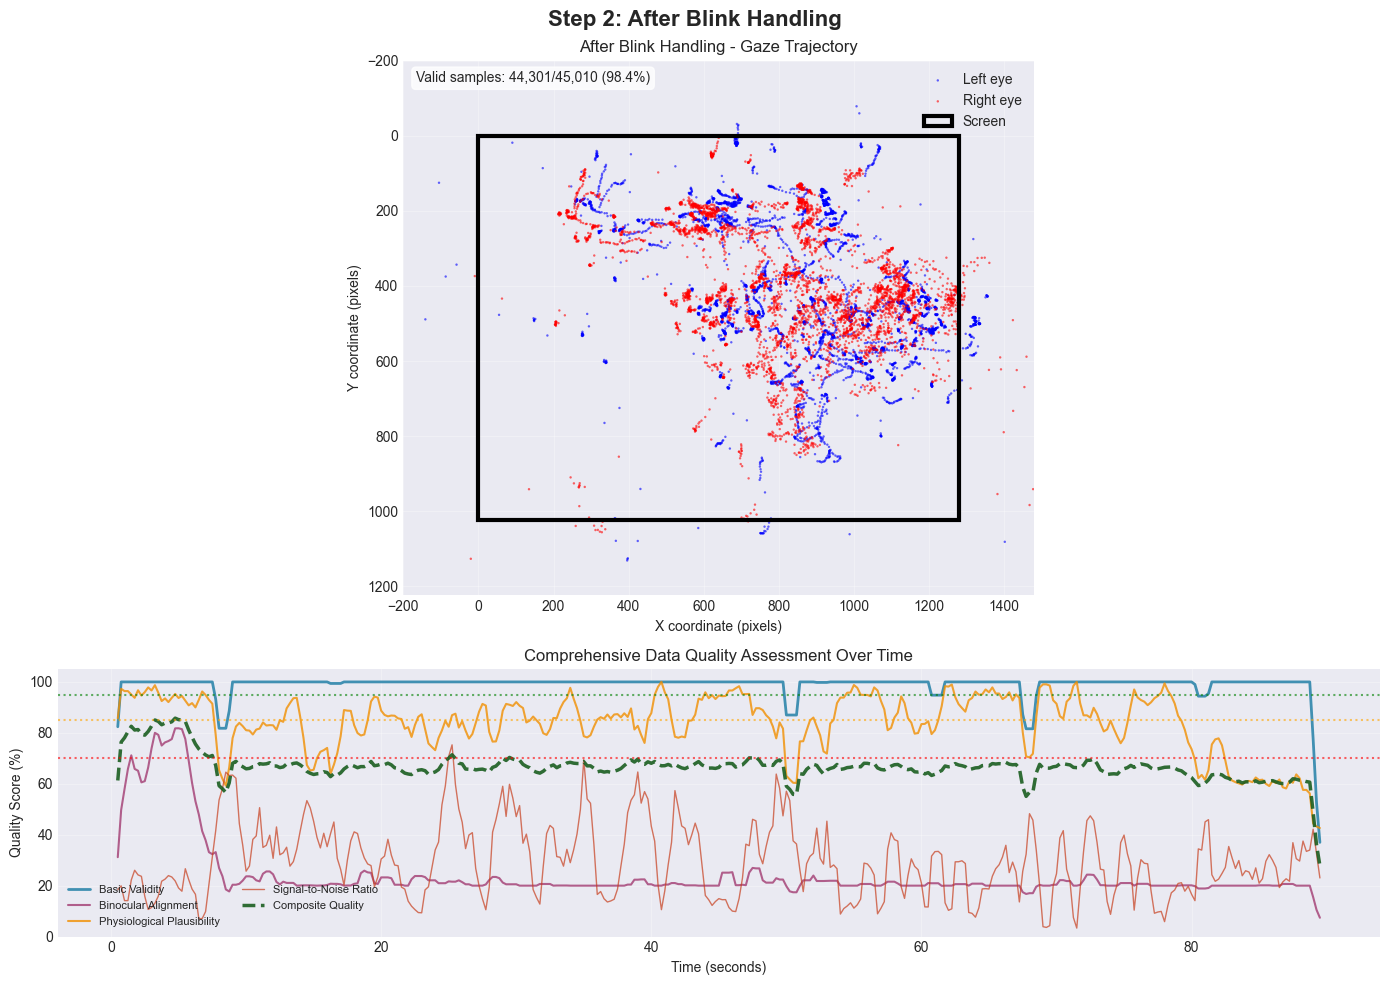

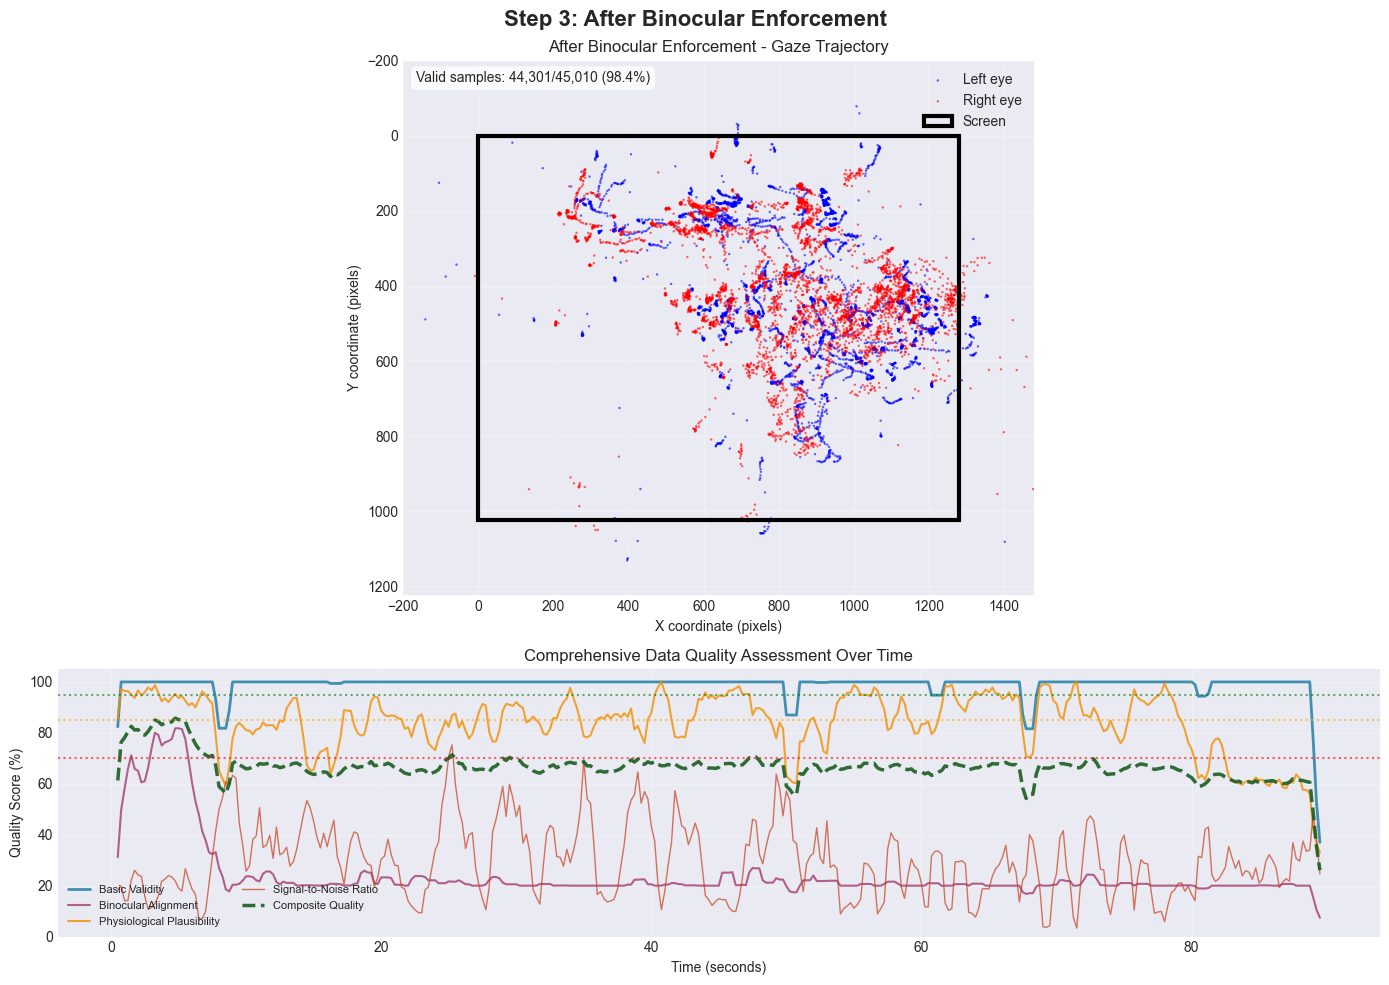

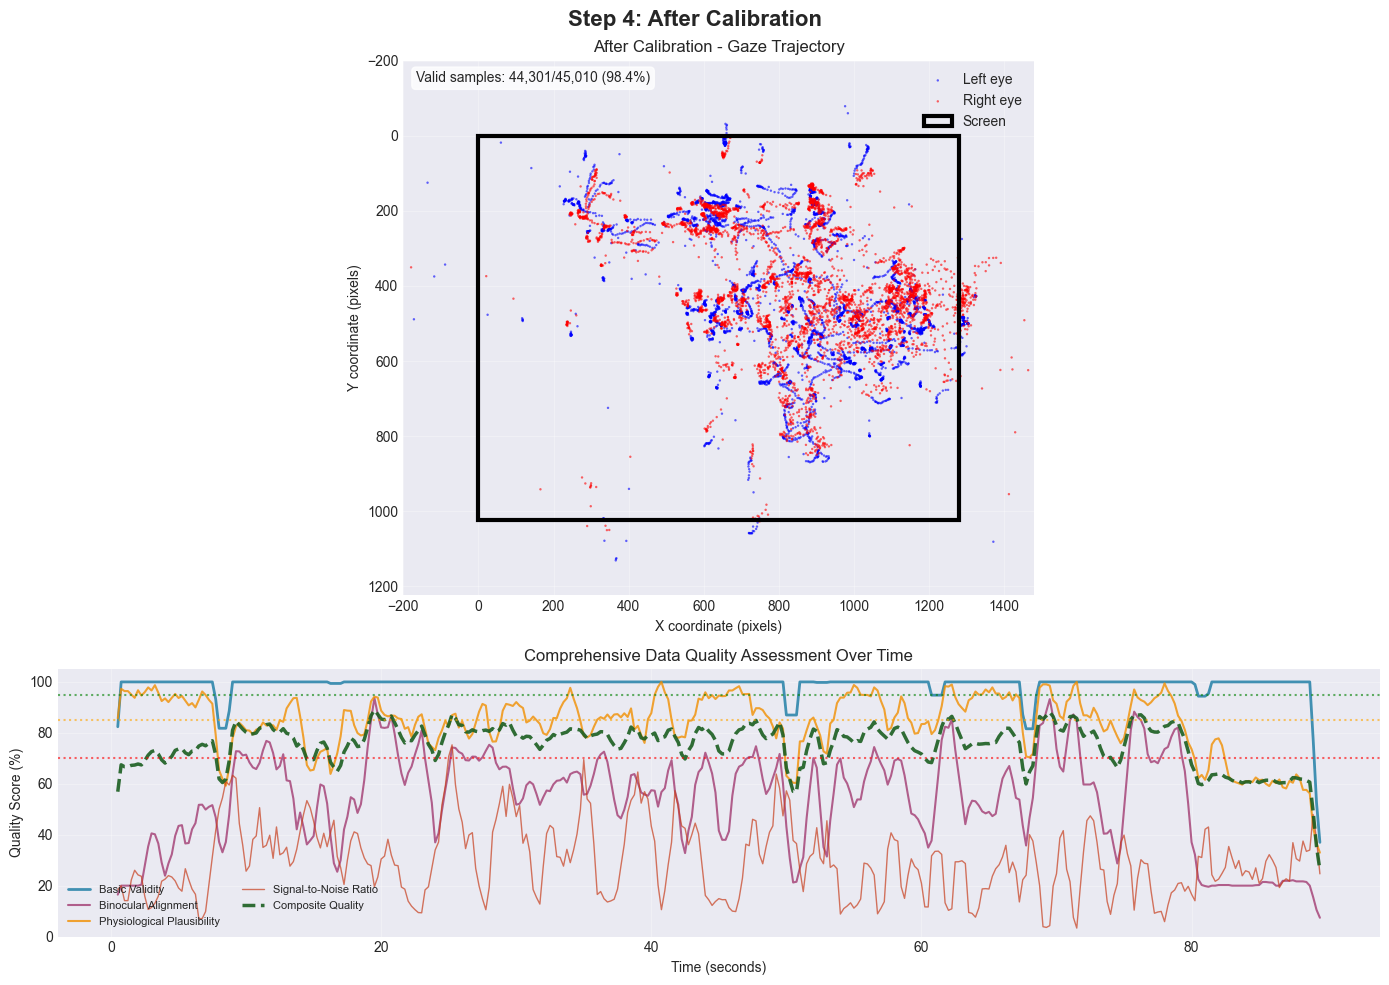

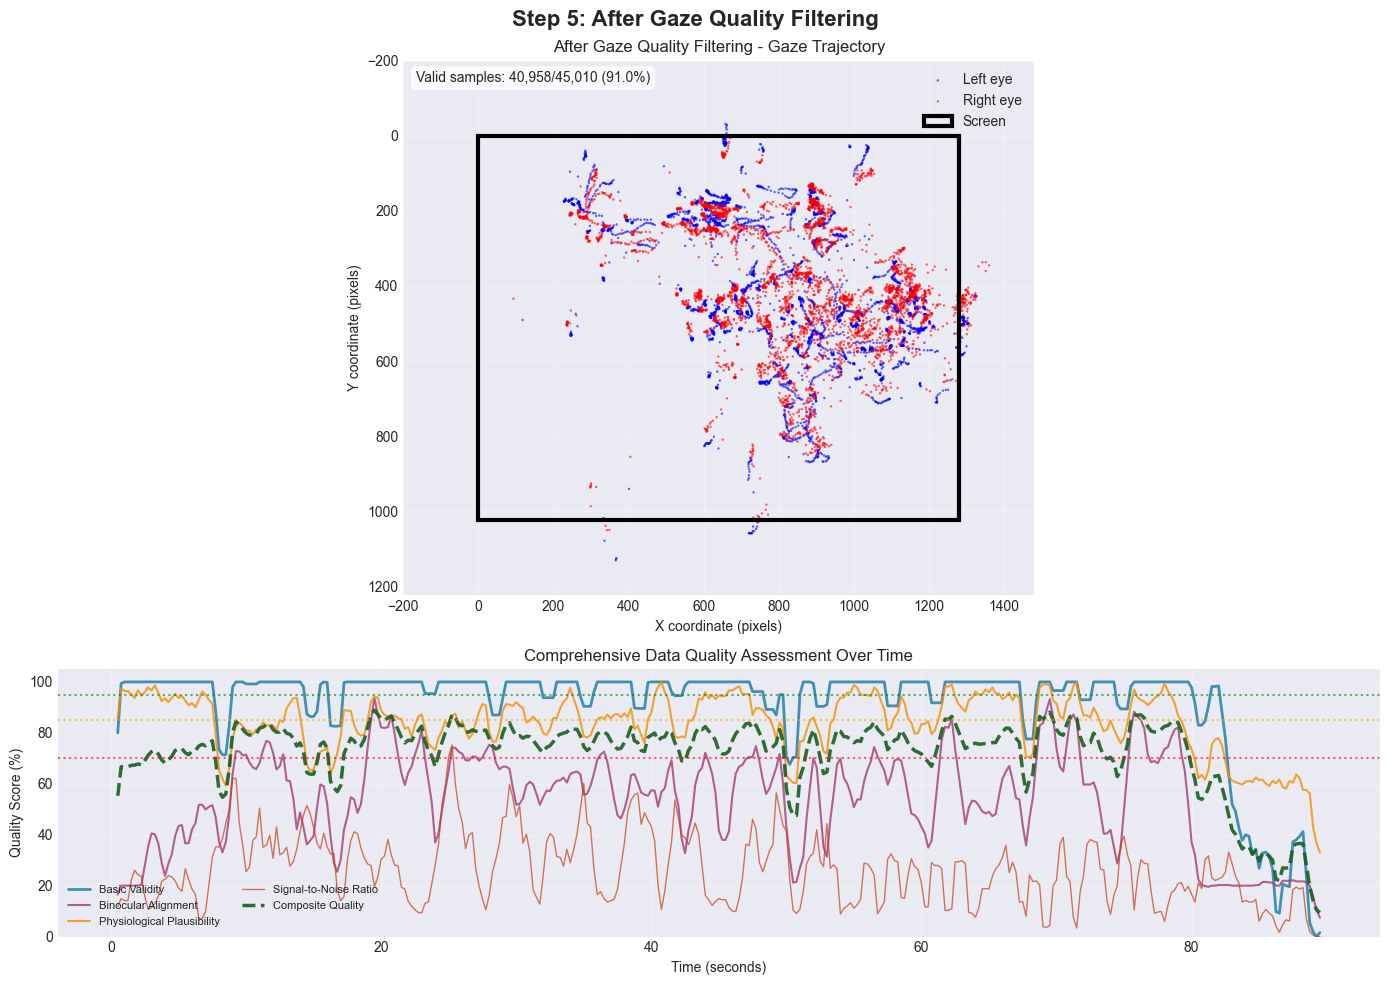

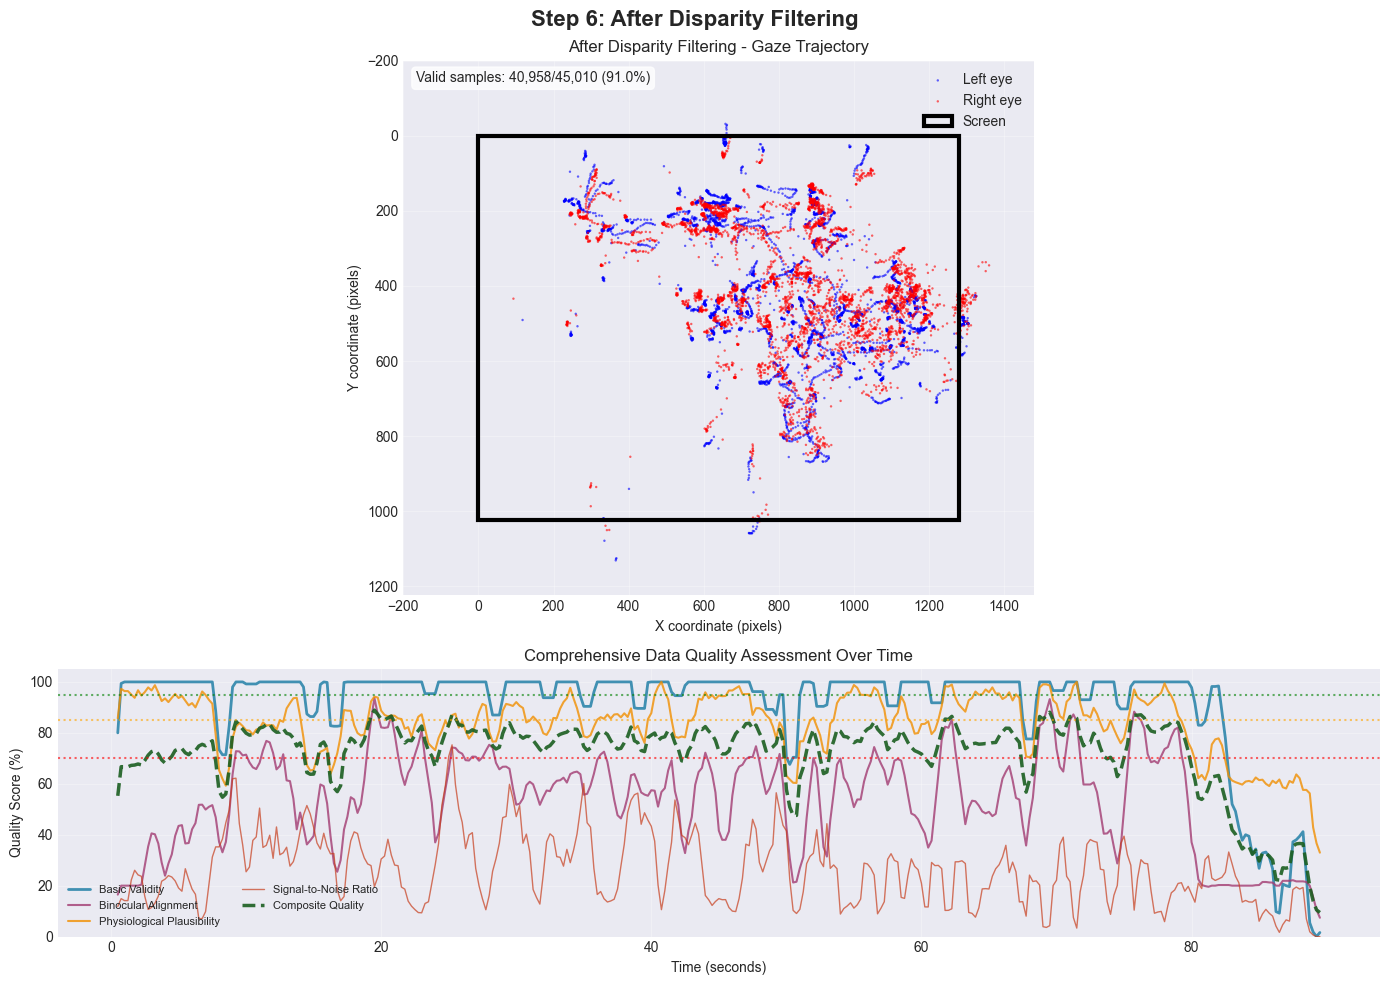

In [9]:
# Check if we have data files available
if len(glob.glob(os.path.join(DATA_DIR, '*.csv'))) > 0:
    sample_file = glob.glob(os.path.join(DATA_DIR, '*.csv'))[0]
    
    # Process with visualization
    df_processed, preprocessing_info = preprocess_eye_tracking_data(
        sample_file,
        verbose=True,
        create_plots=True,
        roi_file_path='files/roi.json'
    )
    
    # Save processed data
    output_file = os.path.join(OUTPUT_DIR, f"{preprocessing_info['subject_id']}_processed.csv")
    df_processed.to_csv(output_file, index=False)
    print(f"✓ Processed data saved to: {output_file}")
else:
    print("⚠️ No CSV files found in the data directory.")

## 5. Quality Assessment

Perform a comprehensive quality assessment of the preprocessed data:

🔍 Calculating comprehensive quality metrics...
📊 Creating comprehensive quality visualization (window size: 1.0s)...


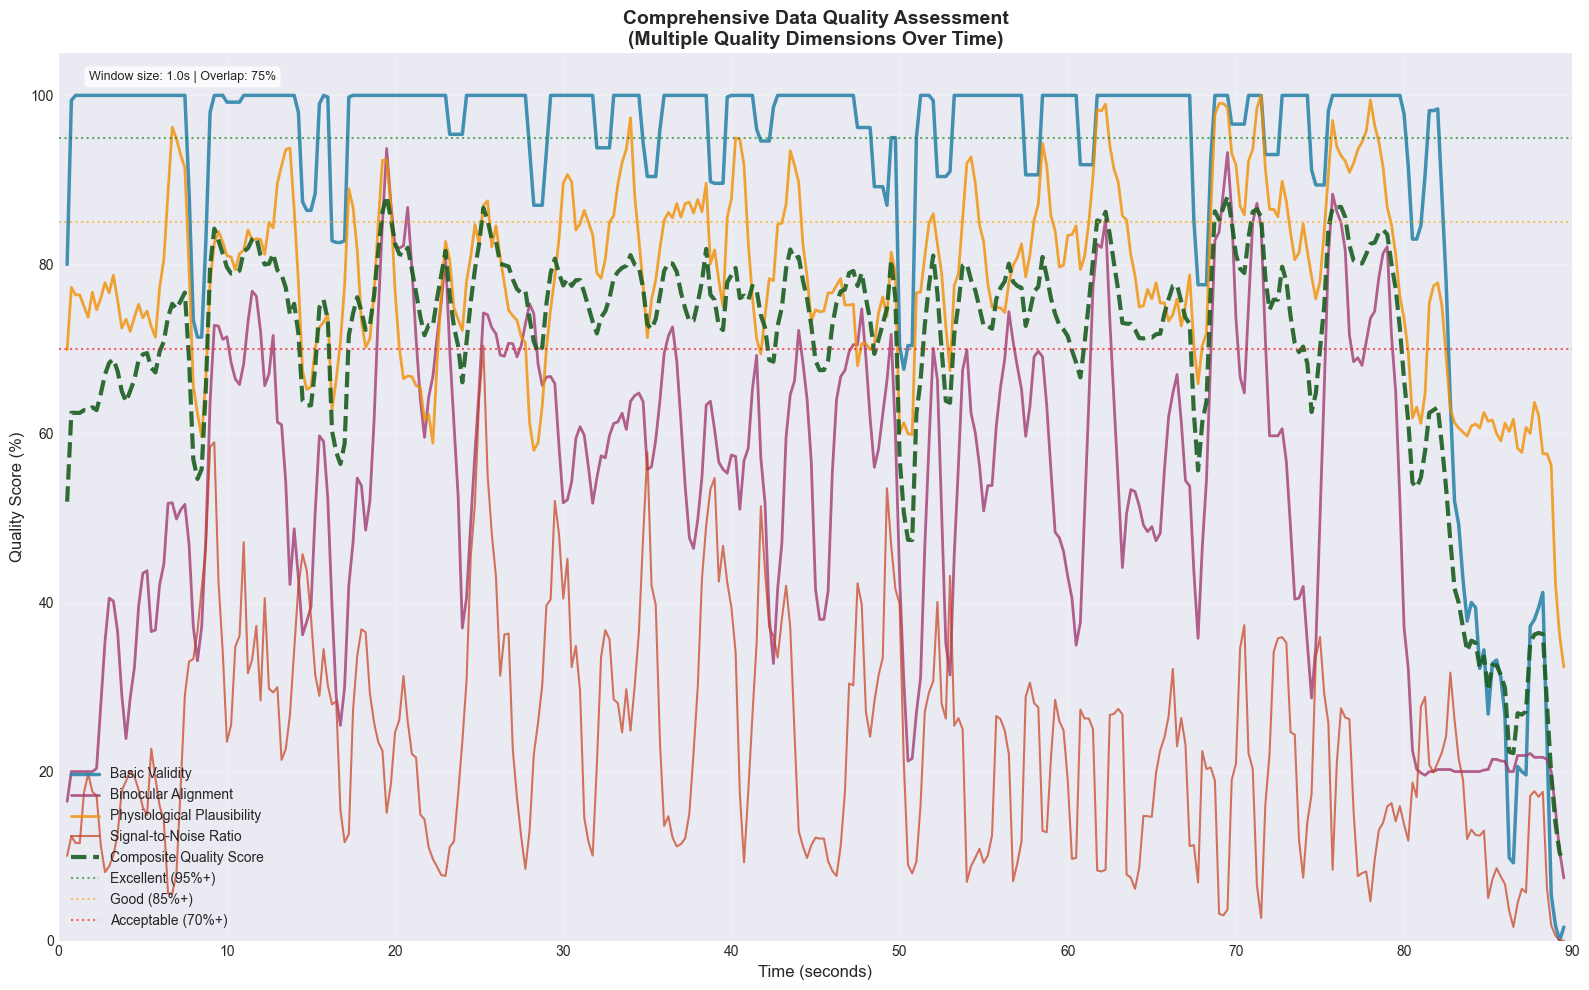

🔍 Calculating comprehensive quality metrics...

📈 Quality Metrics Summary:
Metric                    Mean     Min      Max      Std     
------------------------------------------------------------
Basic Validity            91.5     0.0      100.0    19.7    
Binocular Alignment       53.8     7.4      93.7     19.0    
Physiological Plausibility 78.5     32.4     100.0    10.9    
Signal-to-Noise Ratio     23.3     0.0      70.4     13.0    
Composite Quality         70.8     9.3      88.1     14.2    

🎯 Overall Quality Assessment:
Basic Validity: 91.0%
Binocular Alignment: 53.5%
Physiological Plausibility: 78.2%
Signal-to-Noise Ratio: 23.1%
Composite Quality: 70.4%

Overall Rating: Acceptable (70.4%)


In [4]:
# Check if we have processed data
if 'df_processed' in locals():
    # Calculate quality metrics
    quality_metrics = calculate_comprehensive_quality_metrics(df_processed)
    
    # Plot quality metrics
    fig = plot_comprehensive_quality_trends(quality_metrics)
    plt.show()
    
    # Perform full quality assessment
    quality_assessment = assess_data_quality(df_processed, verbose=True)
else:
    print("⚠️ No processed data available. Run the preprocessing cell first.")

## 6. Feature Extraction

Extract features from the preprocessed data:

In [5]:
# Check if we have processed data
if 'df_processed' in locals():
    # Extract basic features
    features = extract_basic_features(df_processed)
    
    # Display some key features
    print("\n📊 Extracted Features (sample):")
    for key, value in list(features.items())[:10]:
        print(f"   {key}: {value:.3f}")
    
    # Create feature dataframe
    features_df = pd.DataFrame([features])
    print(f"\nFeature dataframe shape: {features_df.shape}")
    print(f"Feature categories: {', '.join([c.split('_')[0] for c in features.keys()if '_' in c][:5])}...")
else:
    print("⚠️ No processed data available. Run the preprocessing cell first.")


📊 Extracted Features (sample):
   valid_samples_ratio: 0.910
   total_duration_seconds: 90.018
   fixation_ratio_left: 0.880
   fixation_ratio_right: 0.798
   fixation_ratio_binocular: 0.783
   saccade_ratio_left: 0.107
   saccade_ratio_right: 0.189
   saccade_ratio_binocular: 0.092
   blink_count_left: 0.958
   blink_count_right: 0.840

Feature dataframe shape: (1, 36)
Feature categories: valid, total, fixation, fixation, fixation...


## 7. Social Attention Analysis

Analyze social attention patterns if ROI data is available:

✅ Loaded ROI data from files/roi.json
   Number of frames with ROI data: 2697
📊 ROI Analysis Summary:
   ROI matches: 19064
   ROI misses: 21894
   Transitions detected: 11


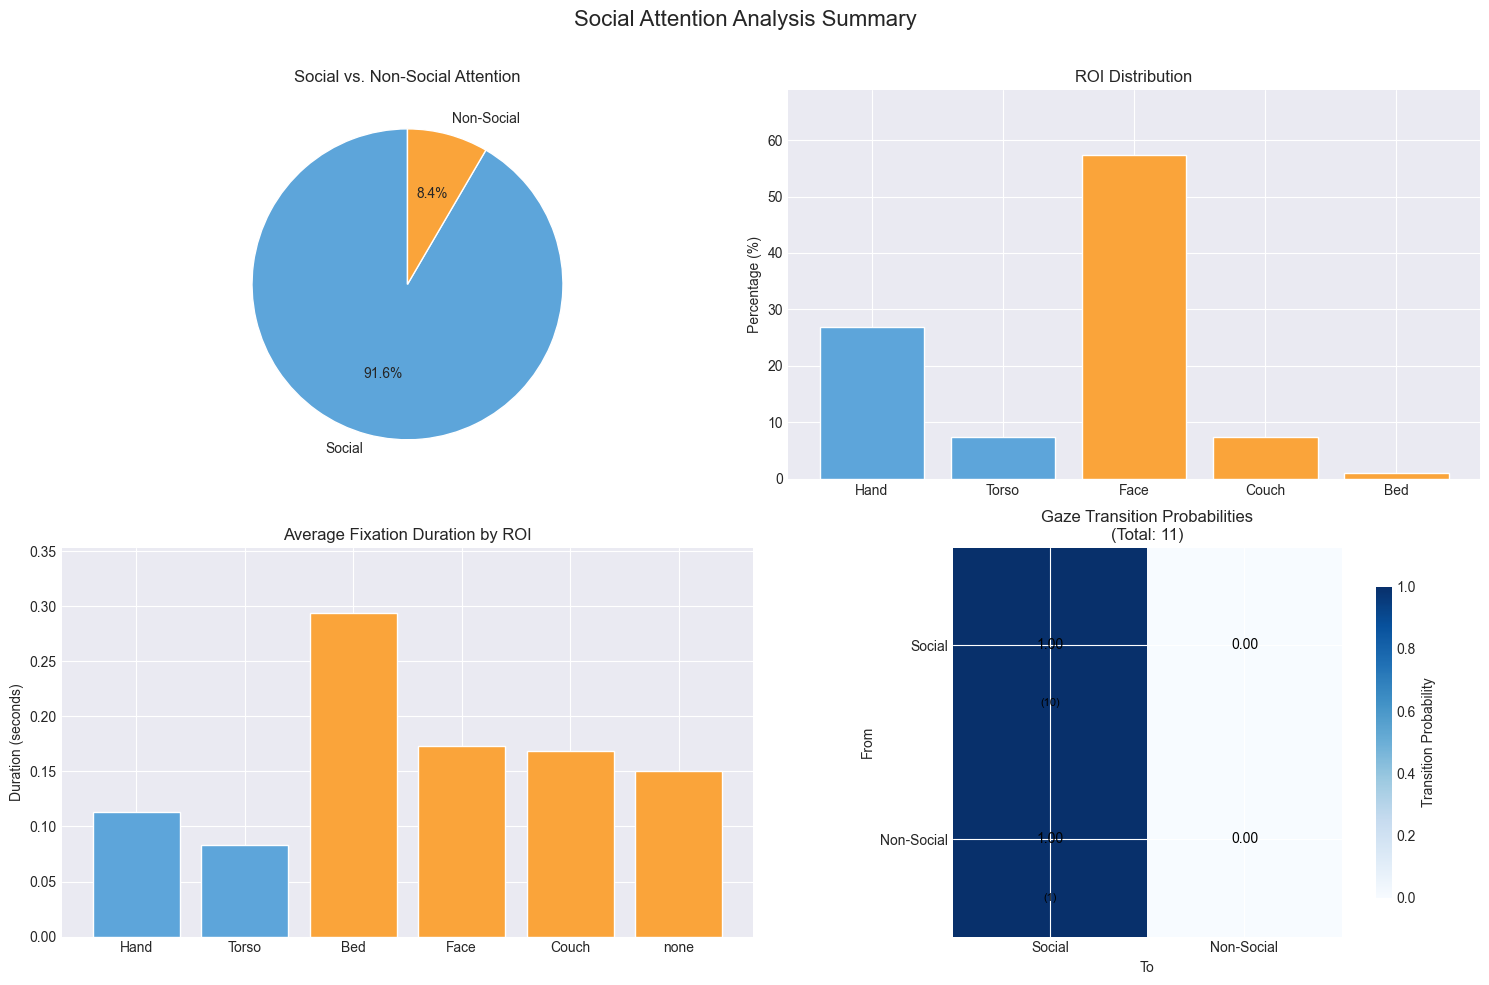

📊 ROI Analysis Summary:
   ROI matches: 19064
   ROI misses: 21894
   Transitions detected: 11
Total features: 60
Social features: 11


In [6]:
# Check if we have processed data and ROI data
roi_file = os.path.join(DATA_DIR, 'roi.json')

if 'df_processed' in locals() and os.path.exists(roi_file):
    # Initialize ROI analyzer
    roi_analyzer = ROIAnalyzer(roi_file)
    
    # Analyze social attention
    social_metrics = roi_analyzer.analyze_gaze_social_attention(df_processed)
    
    # Plot social attention summary
    fig = plot_social_attention_summary(social_metrics)
    plt.show()
    
    # Extract combined features (basic + social)
    combined_features = extract_combined_features(df_processed, roi_analyzer)
    
    # Show number of features
    print(f"Total features: {len(combined_features)}")
    print(f"Social features: {len([f for f in combined_features.keys() if 'social' in f])}")
    
elif 'df_processed' in locals():
    print(f"⚠️ ROI file not found: {roi_file}")
    print("Social attention analysis requires ROI data.")
else:
    print("⚠️ No processed data available. Run the preprocessing cell first.")

## 8. Batch Processing

Process multiple files in batch mode:

In [7]:
# Uncomment to run batch processing
# batch_summary = batch_preprocess_files(
#     create_plots=False,
#     save_preprocessed=True
# )
# 
# # Display summary
# if 'batch_summary' in locals() and len(batch_summary) > 0:
#     print("\nBatch Processing Summary:")
#     print(batch_summary[['subject_id', 'initial_samples', 'final_samples', 'retention_rate']])

## 9. Export & Save

Export results and create reports:

In [8]:
# Check if we have processed data
if 'df_processed' in locals() and 'preprocessing_info' in locals():
    # Save preprocessing report
    report_path = save_preprocessing_report(preprocessing_info, df_processed)
    
    # Save features
    if 'features' in locals():
        features_file = os.path.join(OUTPUT_DIR, f"{preprocessing_info['subject_id']}_features.csv")
        pd.DataFrame([features]).to_csv(features_file, index=False)
        print(f"✓ Features saved to: {features_file}")
    
    # Save combined features if available
    if 'combined_features' in locals():
        combined_file = os.path.join(OUTPUT_DIR, f"{preprocessing_info['subject_id']}_combined_features.csv")
        pd.DataFrame([combined_features]).to_csv(combined_file, index=False)
        print(f"✓ Combined features saved to: {combined_file}")
else:
    print("⚠️ No processed data available. Run the preprocessing cell first.")

✅ Report saved to: output/1024539343_preprocessing_report.txt
✓ Features saved to: output/1024539343_features.csv
✓ Combined features saved to: output/1024539343_combined_features.csv


## 10. References

- **Eye-Tracking Preprocessing**: Holmqvist, K., Nyström, M., Andersson, R., Dewhurst, R., Jarodzka, H., & Van de Weijer, J. (2011). Eye tracking: A comprehensive guide to methods and measures. Oxford University Press.

- **ASD and Eye-Tracking**: Frazier, T. W., Strauss, M., Klingemier, E. W., Zetzer, E. E., Hardan, A. Y., Eng, C., & Youngstrom, E. A. (2017). A meta-analysis of gaze differences to social and nonsocial information between individuals with and without autism. Journal of the American Academy of Child & Adolescent Psychiatry, 56(7), 546-555.

- **Feature Engineering**: Itti, L., & Koch, C. (2001). Computational modelling of visual attention. Nature reviews neuroscience, 2(3), 194-203.

- **Deep Learning for Eye-Tracking**: Wang, S., Jiang, M., Duchesne, X. M., Laugeson, E. A., Kennedy, D. P., Adolphs, R., & Zhao, Q. (2015). Atypical visual saliency in autism spectrum disorder quantified through model-based eye tracking. Neuron, 88(3), 604-616.

---

**Documentation**: See the docstrings in the `src` module files for detailed information on all functions and parameters.